# メーカーごとのデータ数が極端に少ない値を外れ値にして予測  
# encodingをダミーエンコーディングで実装

In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,mean_absolute_percentage_error

import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
import optuna
import matplotlib.pyplot as plt
import japanize_matplotlib

looker studioでパレート図(横軸メーカー、縦軸データ数)を作った結果  
下位10メーカーはデータが2個以下しかないため、使用できないと判断し、外れ値とした。

In [3]:
#データの読み込み
train_data = pd.read_csv("../data/機械学習用/train_data.csv",index_col=0)
model_data = pd.read_csv('../data/アップロード用/model_data.csv',index_col=0)
info_data = pd.read_csv('../data/アップロード用/bike_info.csv',index_col=0)
#サンプルサイズが少ないモデルを抽出
all_data = info_data.merge(model_data,on='model_number',how='left')
brand_count = all_data.groupby('brand').size().sort_values(ascending=True)
#下位10メーカーを抽出(上のcountデータがすでに照準のため上から９つを抽出する)
low_10 = brand_count.index[0:10]
model_data = model_data[~model_data['brand'].isin(low_10)]
#このメーカーデータを使ってtrainデータに結合
train_data = train_data.merge(model_data,on='model_number',how='left')
#先ほど外れ値に指定したデータはnullになるため、dropnaをすればok
train_data.dropna(inplace=True)

In [4]:
train_data

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement
0,2100006155617,118000,JBH-AF67,2012.0,黒,2742.0,0.25,51,HONDA,ﾄｩﾃﾞｲ,スクーター/ビッグスクーター,50.0
1,2100004366077,1378000,EBL-NC42,2019.0,黒,776.0,5.00,2,HONDA,CB400 SUPER FOUR HYPER VTEC Revo,ネイキッド,400.0
2,2100005457217,348000,JBK-ER250C,2013.0,白,11979.0,1.00,58,KAWASAKI,Z250,ネイキッド,250.0
3,2100005346689,568000,JUE4,2021.0,黒,5688.0,5.00,81,Husqvarna,SVARTPILEN 250,ネイキッド,250.0
4,2100005410144,458000,JBK-RG10J,2019.0,青,27167.0,1.00,37,YAMAHA,YZFR25,スポーツ/ツアラー,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4484,2100006097726,1018000,8BL-RM39J,2022.0,青,2964.0,7.00,67,YAMAHA,YZFR7,スポーツ/ツアラー,700.0
4485,2100006214697,798000,BC-SK44A,2008.0,黒,11745.0,0.25,3,SUZUKI,DRZ400SM,オフロード/モタード,400.0
4486,2100006202625,1198000,EBL-SC59,2013.0,オレンジ,23013.0,1.00,74,HONDA,CBR1000RR,スポーツ/ツアラー,1000.0
4487,2100006271508,466000,JBK-RG10J,2019.0,赤,5895.0,5.00,54,YAMAHA,YZFR25,スポーツ/ツアラー,250.0


# モデルの作成  
使用する特徴量  
* model_year
* color
* mileage 
* gurantee_period
* brand
* type
* displacement  

In [5]:
#ダミーエンコーディング  
#色、ブランド、typeは名義尺度のため、本来ラベルエンコーディングは不適当なため、dummy変数化
#oe =OrdinalEncoder()
#エンコーディングしたい列
encoding_target = ['color','brand','type']
#train_data[encoding_target] = oe.fit_transform(train_data[encoding_target].values)

In [6]:
train_data=pd.get_dummies(train_data,drop_first=True,columns=encoding_target)

In [7]:
#説明変数と目的変数の抽出
X = train_data.iloc[:,2:].drop(columns=['model_number','name','store_id']).values
y = train_data['cost'].values

In [8]:
#学習データと検証データへの分割
X_learn,X_val,y_learn,y_val = train_test_split(X,y,test_size=0.2,random_state=123)

In [9]:
lr_ds = opt_lgb.Dataset(X_learn,y_learn)
val_ds = opt_lgb.Dataset(X_val,y_val)

#固定するparamsは先に指定
params ={
    'objective':'regression',
    'metric':'mape'
}

#クロスバリデーションによるパラメータの探索 5Fold
tuner = opt_lgb.LightGBMTunerCV(params,
                                lr_ds,
                                num_boost_round=10000,
                                verbose_eval=1,
                                early_stopping_rounds=100,
                                folds =KFold(n_splits=5))

tuner.run()

[I 2023-12-15 10:22:28,360] A new study created in memory with name: no-name-23c844ff-2e2e-4c49-a999-bf6dbc3dea09
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

feature_fraction, val_score: 0.192100:  14%|#4        | 1/7 [00:03<00:18,  3.05s/it]

[232]	cv_agg's valid mape: 0.193236 + 0.00688548
[233]	cv_agg's valid mape: 0.193132 + 0.00685422
[234]	cv_agg's valid mape: 0.193371 + 0.0067927
[235]	cv_agg's valid mape: 0.193259 + 0.00667516
[236]	cv_agg's valid mape: 0.193212 + 0.00663293
[237]	cv_agg's valid mape: 0.193305 + 0.00656984
[238]	cv_agg's valid mape: 0.193161 + 0.00656753
[239]	cv_agg's valid mape: 0.19304 + 0.00661227
[240]	cv_agg's valid mape: 0.192847 + 0.00666396
Early stopping, best iteration is:
[140]	cv_agg's valid mape: 0.1921 + 0.00592769
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4

feature_fraction, val_score: 0.181961:  29%|##8       | 2/7 [00:05<00:14,  2.92s/it]

[236]	cv_agg's valid mape: 0.183869 + 0.00643839
[237]	cv_agg's valid mape: 0.184001 + 0.0065611
Early stopping, best iteration is:
[137]	cv_agg's valid mape: 0.181961 + 0.00674136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the tra

feature_fraction, val_score: 0.179974:  43%|####2     | 3/7 [00:08<00:11,  2.85s/it]

[226]	cv_agg's valid mape: 0.181021 + 0.00780901
[227]	cv_agg's valid mape: 0.181071 + 0.00783588
[228]	cv_agg's valid mape: 0.18113 + 0.00785653
[229]	cv_agg's valid mape: 0.181058 + 0.00783516
[230]	cv_agg's valid mape: 0.18119 + 0.00795152
[231]	cv_agg's valid mape: 0.181149 + 0.00791833
[232]	cv_agg's valid mape: 0.181146 + 0.00789019
[233]	cv_agg's valid mape: 0.181028 + 0.00779975
Early stopping, best iteration is:
[133]	cv_agg's valid mape: 0.179974 + 0.00728752
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in t

feature_fraction, val_score: 0.179974:  57%|#####7    | 4/7 [00:11<00:08,  2.88s/it]

[232]	cv_agg's valid mape: 0.187277 + 0.00471597
[233]	cv_agg's valid mape: 0.187254 + 0.00479029
[234]	cv_agg's valid mape: 0.187375 + 0.00484915
[235]	cv_agg's valid mape: 0.187324 + 0.00485541
[236]	cv_agg's valid mape: 0.187265 + 0.00495224
[237]	cv_agg's valid mape: 0.18742 + 0.00496819
[238]	cv_agg's valid mape: 0.187431 + 0.00489529
[239]	cv_agg's valid mape: 0.18734 + 0.00485092
[240]	cv_agg's valid mape: 0.187144 + 0.00480369
Early stopping, best iteration is:
[140]	cv_agg's valid mape: 0.185566 + 0.0043375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 

feature_fraction, val_score: 0.179974:  71%|#######1  | 5/7 [00:15<00:06,  3.36s/it]

[331]	cv_agg's valid mape: 0.202843 + 0.00632387
[332]	cv_agg's valid mape: 0.202977 + 0.00624588
[333]	cv_agg's valid mape: 0.202926 + 0.00618551
[334]	cv_agg's valid mape: 0.202976 + 0.00621434
[335]	cv_agg's valid mape: 0.202894 + 0.00618602
[336]	cv_agg's valid mape: 0.202858 + 0.0061637
[337]	cv_agg's valid mape: 0.202888 + 0.00613851
[338]	cv_agg's valid mape: 0.202956 + 0.00621466
[339]	cv_agg's valid mape: 0.202715 + 0.00619025
[340]	cv_agg's valid mape: 0.202751 + 0.00618157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	cv_agg's valid mape: 0.202784 + 0.00624037
[342]	cv_agg's valid mape: 0.202864 + 0.00634891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

feature_fraction, val_score: 0.178818:  86%|########5 | 6/7 [00:18<00:03,  3.16s/it]

[230]	cv_agg's valid mape: 0.181055 + 0.00569133
Early stopping, best iteration is:
[130]	cv_agg's valid mape: 0.178818 + 0.00654407
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[Light

feature_fraction, val_score: 0.177748: 100%|##########| 7/7 [00:20<00:00,  2.97s/it]


[170]	cv_agg's valid mape: 0.180142 + 0.0071913
[171]	cv_agg's valid mape: 0.179939 + 0.00719066
[172]	cv_agg's valid mape: 0.179939 + 0.00718721
[173]	cv_agg's valid mape: 0.179841 + 0.00713465
[174]	cv_agg's valid mape: 0.179782 + 0.00715106
[175]	cv_agg's valid mape: 0.179894 + 0.00711893
[176]	cv_agg's valid mape: 0.179908 + 0.0069956
[177]	cv_agg's valid mape: 0.179875 + 0.00696494
[178]	cv_agg's valid mape: 0.179838 + 0.00688815
[179]	cv_agg's valid mape: 0.179775 + 0.00683905
[180]	cv_agg's valid mape: 0.179748 + 0.00674637
[181]	cv_agg's valid mape: 0.179814 + 0.00670924
[182]	cv_agg's valid mape: 0.179996 + 0.00668894
[183]	cv_agg's valid mape: 0.179994 + 0.00675882
[184]	cv_agg's valid mape: 0.179739 + 0.00670453
Early stopping, best iteration is:
[84]	cv_agg's valid mape: 0.177748 + 0.00798786


num_leaves, val_score: 0.177748:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` t

num_leaves, val_score: 0.166749:   5%|5         | 1/20 [00:06<01:55,  6.09s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	cv_agg's valid mape: 0.173841 + 0.00499884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	cv_agg's valid mape: 0.173685 + 0.0048488
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

num_leaves, val_score: 0.166588:  10%|#         | 2/20 [00:10<01:35,  5.33s/it]

[155]	cv_agg's valid mape: 0.172457 + 0.00572592
[156]	cv_agg's valid mape: 0.172547 + 0.00574129
[157]	cv_agg's valid mape: 0.172631 + 0.00564151
[158]	cv_agg's valid mape: 0.172677 + 0.00572993
[159]	cv_agg's valid mape: 0.17276 + 0.00572095
Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.166588 + 0.00724987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seco

num_leaves, val_score: 0.166588:  15%|#5        | 3/20 [00:16<01:34,  5.56s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	cv_agg's valid mape: 0.173734 + 0.0048803
Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.166749 + 0.00555862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remo

num_leaves, val_score: 0.166588:  20%|##        | 4/20 [00:18<01:06,  4.15s/it]

[230]	cv_agg's valid mape: 0.182318 + 0.00972997
[231]	cv_agg's valid mape: 0.182294 + 0.00987185
[232]	cv_agg's valid mape: 0.182272 + 0.00984504
[233]	cv_agg's valid mape: 0.182094 + 0.00990124
[234]	cv_agg's valid mape: 0.182186 + 0.00988846
[235]	cv_agg's valid mape: 0.182203 + 0.00995734
[236]	cv_agg's valid mape: 0.18215 + 0.00997258
[237]	cv_agg's valid mape: 0.182085 + 0.0100289
[238]	cv_agg's valid mape: 0.182072 + 0.00999717
[239]	cv_agg's valid mape: 0.182115 + 0.0100388
[240]	cv_agg's valid mape: 0.182132 + 0.0100376
[241]	cv_agg's valid mape: 0.181822 + 0.0100586
[242]	cv_agg's valid mape: 0.181752 + 0.0100493
[243]	cv_agg's valid mape: 0.181829 + 0.0100441
[244]	cv_agg's valid mape: 0.181815 + 0.00998884
[245]	cv_agg's valid mape: 0.181735 + 0.00994944
[246]	cv_agg's valid mape: 0.181731 + 0.00982397
[247]	cv_agg's valid mape: 0.181772 + 0.00970817
[248]	cv_agg's valid mape: 0.181752 + 0.00973745
[249]	cv_agg's valid mape: 0.181836 + 0.00973253
[250]	cv_agg's valid mape: 

num_leaves, val_score: 0.166260:  25%|##5       | 5/20 [00:24<01:11,  4.78s/it]

[151]	cv_agg's valid mape: 0.173045 + 0.00530582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	cv_agg's valid mape: 0.173035 + 0.0053616
Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.16626 + 0.00692949
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 se

num_leaves, val_score: 0.164883:  30%|###       | 6/20 [00:30<01:10,  5.05s/it]

[154]	cv_agg's valid mape: 0.172799 + 0.00480035
Early stopping, best iteration is:
[54]	cv_agg's valid mape: 0.164883 + 0.00584212
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightG

num_leaves, val_score: 0.164883:  35%|###5      | 7/20 [00:36<01:10,  5.42s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	cv_agg's valid mape: 0.173801 + 0.00500794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	cv_agg's valid mape: 0.173841 + 0.00499884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

num_leaves, val_score: 0.164883:  40%|####      | 8/20 [00:42<01:07,  5.59s/it]

[161]	cv_agg's valid mape: 0.174005 + 0.00501185
[162]	cv_agg's valid mape: 0.174063 + 0.00493487
[163]	cv_agg's valid mape: 0.174179 + 0.00498475
[164]	cv_agg's valid mape: 0.17421 + 0.00484688
Early stopping, best iteration is:
[64]	cv_agg's valid mape: 0.166984 + 0.00603936
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove 

num_leaves, val_score: 0.164883:  45%|####5     | 9/20 [00:48<01:03,  5.74s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	cv_agg's valid mape: 0.173734 + 0.0048803
Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.166749 + 0.00555862
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Numbe

num_leaves, val_score: 0.164883:  50%|#####     | 10/20 [00:51<00:49,  4.97s/it]

[161]	cv_agg's valid mape: 0.17322 + 0.00623468
[162]	cv_agg's valid mape: 0.173244 + 0.00624448
[163]	cv_agg's valid mape: 0.173243 + 0.00634926
[164]	cv_agg's valid mape: 0.173183 + 0.0063434
[165]	cv_agg's valid mape: 0.173272 + 0.00646014
[166]	cv_agg's valid mape: 0.17327 + 0.00651375
[167]	cv_agg's valid mape: 0.173321 + 0.00667139
Early stopping, best iteration is:
[67]	cv_agg's valid mape: 0.169008 + 0.00627191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of dat

num_leaves, val_score: 0.164883:  55%|#####5    | 11/20 [00:57<00:47,  5.28s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	cv_agg's valid mape: 0.173801 + 0.00500794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	cv_agg's valid mape: 0.173841 + 0.00499884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	cv_agg's valid mape: 0.173685 + 0.0048488
[LightGBM] [Warning] No furth

num_leaves, val_score: 0.164883:  60%|######    | 12/20 [01:01<00:38,  4.81s/it]

[155]	cv_agg's valid mape: 0.17204 + 0.00616657
[156]	cv_agg's valid mape: 0.172146 + 0.00620799
Early stopping, best iteration is:
[56]	cv_agg's valid mape: 0.16607 + 0.00713943
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train

num_leaves, val_score: 0.164883:  65%|######5   | 13/20 [01:04<00:29,  4.20s/it]

[1508]	cv_agg's valid mape: 0.220748 + 0.00967774
[1509]	cv_agg's valid mape: 0.220765 + 0.00964519
[1510]	cv_agg's valid mape: 0.220816 + 0.00964301
[1511]	cv_agg's valid mape: 0.220782 + 0.00963577
Early stopping, best iteration is:
[1411]	cv_agg's valid mape: 0.220712 + 0.00998761
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of tes

num_leaves, val_score: 0.164883:  70%|#######   | 14/20 [01:07<00:24,  4.04s/it]

[168]	cv_agg's valid mape: 0.173064 + 0.00610239
[169]	cv_agg's valid mape: 0.173119 + 0.00595062
[170]	cv_agg's valid mape: 0.173206 + 0.00599251
Early stopping, best iteration is:
[70]	cv_agg's valid mape: 0.168473 + 0.00637263
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[

num_leaves, val_score: 0.164883:  75%|#######5  | 15/20 [01:13<00:22,  4.52s/it]

[154]	cv_agg's valid mape: 0.17245 + 0.00572102
[155]	cv_agg's valid mape: 0.172581 + 0.00578016
[156]	cv_agg's valid mape: 0.172618 + 0.00591252
[157]	cv_agg's valid mape: 0.172787 + 0.00589118
Early stopping, best iteration is:
[57]	cv_agg's valid mape: 0.165369 + 0.0053341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove t

num_leaves, val_score: 0.164883:  80%|########  | 16/20 [01:17<00:17,  4.43s/it]

[164]	cv_agg's valid mape: 0.172919 + 0.00628364
[165]	cv_agg's valid mape: 0.173017 + 0.00637024
Early stopping, best iteration is:
[65]	cv_agg's valid mape: 0.167144 + 0.00605927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the tra

num_leaves, val_score: 0.164883:  85%|########5 | 17/20 [01:23<00:14,  4.82s/it]

[151]	cv_agg's valid mape: 0.173652 + 0.00480575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	cv_agg's valid mape: 0.173734 + 0.0048803
Early stopping, best iteration is:
[52]	cv_agg's valid mape: 0.166749 + 0.00555862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhe

num_leaves, val_score: 0.164883:  90%|######### | 18/20 [01:25<00:08,  4.12s/it]

[164]	cv_agg's valid mape: 0.17688 + 0.00739259
[165]	cv_agg's valid mape: 0.176928 + 0.00742462
[166]	cv_agg's valid mape: 0.176948 + 0.00742276
[167]	cv_agg's valid mape: 0.176912 + 0.00740585
[168]	cv_agg's valid mape: 0.177035 + 0.0072522
[169]	cv_agg's valid mape: 0.176974 + 0.00729778
Early stopping, best iteration is:
[69]	cv_agg's valid mape: 0.174478 + 0.00807779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-thre

num_leaves, val_score: 0.164883:  95%|#########5| 19/20 [01:30<00:04,  4.36s/it]

[149]	cv_agg's valid mape: 0.171846 + 0.00637558
[150]	cv_agg's valid mape: 0.17191 + 0.00626437
[151]	cv_agg's valid mape: 0.172118 + 0.00628505
[152]	cv_agg's valid mape: 0.172386 + 0.0062551
[153]	cv_agg's valid mape: 0.17233 + 0.00625503
[154]	cv_agg's valid mape: 0.172496 + 0.00632272
Early stopping, best iteration is:
[54]	cv_agg's valid mape: 0.165923 + 0.00634031
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threa

num_leaves, val_score: 0.164883: 100%|##########| 20/20 [01:36<00:00,  4.82s/it]


[157]	cv_agg's valid mape: 0.172787 + 0.00589118
Early stopping, best iteration is:
[57]	cv_agg's valid mape: 0.165369 + 0.0053341


bagging, val_score: 0.164883:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` t

bagging, val_score: 0.164883:  10%|#         | 1/10 [00:04<00:42,  4.72s/it][I 2023-12-15 10:24:30,349] Trial 27 finished with value: 0.16812989978157125 and parameters: {'bagging_fraction': 0.6870031857791932, 'bagging_freq': 1}. Best is trial 27 with value: 0.16812989978157125.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	cv_agg's valid mape: 0.17285 + 0.00692669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	cv_agg's valid mape: 0.173143 + 0.00680183
Early stopping, best iteration is:
[76]	cv_agg's valid mape: 0.16813 + 0.00803175


bagging, val_score: 0.164883:  10%|#         | 1/10 [00:04<00:42,  4.72s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` t

bagging, val_score: 0.164883:  20%|##        | 2/10 [00:10<00:43,  5.47s/it]

[153]	cv_agg's valid mape: 0.172622 + 0.0055827
[154]	cv_agg's valid mape: 0.1726 + 0.00566467
Early stopping, best iteration is:
[54]	cv_agg's valid mape: 0.165177 + 0.00677534
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train 

bagging, val_score: 0.164883:  30%|###       | 3/10 [00:16<00:40,  5.73s/it]

[153]	cv_agg's valid mape: 0.172881 + 0.00645749
[154]	cv_agg's valid mape: 0.172938 + 0.00661878
[155]	cv_agg's valid mape: 0.172937 + 0.00670573
[156]	cv_agg's valid mape: 0.173039 + 0.00670242
[157]	cv_agg's valid mape: 0.173109 + 0.00665246
[158]	cv_agg's valid mape: 0.173186 + 0.00666546
Early stopping, best iteration is:
[58]	cv_agg's valid mape: 0.166136 + 0.0068052
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-thr

bagging, val_score: 0.164883:  40%|####      | 4/10 [00:22<00:34,  5.76s/it]

[148]	cv_agg's valid mape: 0.171748 + 0.00436663
[149]	cv_agg's valid mape: 0.171827 + 0.00438279
[150]	cv_agg's valid mape: 0.171991 + 0.00422738
[151]	cv_agg's valid mape: 0.172051 + 0.00421537
[152]	cv_agg's valid mape: 0.172187 + 0.00423875
[153]	cv_agg's valid mape: 0.172377 + 0.004195
Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.165549 + 0.00629478
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-thre

bagging, val_score: 0.164883:  50%|#####     | 5/10 [00:25<00:24,  4.85s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	cv_agg's valid mape: 0.184822 + 0.0039905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[179]	cv_agg's valid mape: 0.18485 + 0.00435457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

bagging, val_score: 0.164883:  60%|######    | 6/10 [00:31<00:20,  5.22s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	cv_agg's valid mape: 0.172384 + 0.00366247
[168]	cv_agg's valid mape: 0.17234 + 0.00366712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	cv_agg's valid mape: 0.172267 + 0.00366513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	cv_agg's valid mape: 0.17226 + 0.00369013
Early stopping, best iteration is:
[70]	cv_agg's valid mape: 0.167431 + 0.00775395
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[Li

bagging, val_score: 0.164883:  70%|#######   | 7/10 [00:38<00:16,  5.57s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	cv_agg's valid mape: 0.176189 + 0.00901835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	cv_agg's valid mape: 0.176146 + 0.00903377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

bagging, val_score: 0.164883:  80%|########  | 8/10 [00:43<00:11,  5.64s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	cv_agg's valid mape: 0.172101 + 0.00619162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	cv_agg's valid mape: 0.172164 + 0.00603061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

bagging, val_score: 0.164883:  90%|######### | 9/10 [00:47<00:05,  5.12s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	cv_agg's valid mape: 0.176155 + 0.00846255
Early stopping, best iteration is:
[64]	cv_agg's valid mape: 0.170665 + 0.00691935
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to rem

bagging, val_score: 0.164883: 100%|##########| 10/10 [00:53<00:00,  5.34s/it]


[154]	cv_agg's valid mape: 0.172369 + 0.00459064
[155]	cv_agg's valid mape: 0.17235 + 0.00446065
Early stopping, best iteration is:
[55]	cv_agg's valid mape: 0.166101 + 0.00713359


feature_fraction_stage2, val_score: 0.164883:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` t

feature_fraction_stage2, val_score: 0.164883:  33%|###3      | 1/3 [00:05<00:10,  5.31s/it]

[157]	cv_agg's valid mape: 0.173986 + 0.0065604
[158]	cv_agg's valid mape: 0.173969 + 0.00658184
[159]	cv_agg's valid mape: 0.174095 + 0.00672873
[160]	cv_agg's valid mape: 0.174123 + 0.00676164
Early stopping, best iteration is:
[60]	cv_agg's valid mape: 0.165628 + 0.00729312
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove 

feature_fraction_stage2, val_score: 0.164883:  67%|######6   | 2/3 [00:10<00:05,  5.20s/it]

[152]	cv_agg's valid mape: 0.172657 + 0.00485753
[153]	cv_agg's valid mape: 0.172743 + 0.0048066
[154]	cv_agg's valid mape: 0.172799 + 0.00480035
Early stopping, best iteration is:
[54]	cv_agg's valid mape: 0.164883 + 0.00584212
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[L

feature_fraction_stage2, val_score: 0.164883: 100%|##########| 3/3 [00:15<00:00,  5.21s/it]


[152]	cv_agg's valid mape: 0.173822 + 0.00626511
[153]	cv_agg's valid mape: 0.174032 + 0.00633717
[154]	cv_agg's valid mape: 0.174078 + 0.00638902
[155]	cv_agg's valid mape: 0.174017 + 0.0063404
Early stopping, best iteration is:
[55]	cv_agg's valid mape: 0.165094 + 0.0059333


regularization_factors, val_score: 0.164883:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` t

regularization_factors, val_score: 0.164883:   5%|5         | 1/20 [00:05<01:40,  5.30s/it]

[161]	cv_agg's valid mape: 0.173248 + 0.00495839
[162]	cv_agg's valid mape: 0.173438 + 0.00514674
Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.166288 + 0.00655166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] T

regularization_factors, val_score: 0.164883:  10%|#         | 2/20 [00:10<01:35,  5.31s/it]

[153]	cv_agg's valid mape: 0.173275 + 0.00508663
Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.165132 + 0.00576143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightG

regularization_factors, val_score: 0.164883:  15%|#5        | 3/20 [00:15<01:28,  5.20s/it]

[152]	cv_agg's valid mape: 0.173114 + 0.00513654
[153]	cv_agg's valid mape: 0.173275 + 0.00508663
Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.165132 + 0.00576143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the tra

regularization_factors, val_score: 0.164883:  20%|##        | 4/20 [00:20<01:22,  5.16s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` t

regularization_factors, val_score: 0.164883:  25%|##5       | 5/20 [00:25<01:16,  5.13s/it]

[152]	cv_agg's valid mape: 0.173114 + 0.00513654
[153]	cv_agg's valid mape: 0.173275 + 0.00508663
Early stopping, best iteration is:
[53]	cv_agg's valid mape: 0.165132 + 0.00576143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the tra

regularization_factors, val_score: 0.164883:  30%|###       | 6/20 [00:31<01:13,  5.23s/it]

[160]	cv_agg's valid mape: 0.172238 + 0.00616403
[161]	cv_agg's valid mape: 0.17218 + 0.00614835
[162]	cv_agg's valid mape: 0.172135 + 0.00601093
Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.16506 + 0.00670751
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[Li

regularization_factors, val_score: 0.164883:  35%|###5      | 7/20 [00:36<01:08,  5.25s/it]

[154]	cv_agg's valid mape: 0.172925 + 0.00667773
[155]	cv_agg's valid mape: 0.172964 + 0.00660551
[156]	cv_agg's valid mape: 0.173151 + 0.00653205
[157]	cv_agg's valid mape: 0.173154 + 0.00654854
[158]	cv_agg's valid mape: 0.17325 + 0.00660056
Early stopping, best iteration is:
[58]	cv_agg's valid mape: 0.165586 + 0.00562196
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seco

regularization_factors, val_score: 0.164883:  40%|####      | 8/20 [00:41<01:02,  5.22s/it]

[154]	cv_agg's valid mape: 0.171993 + 0.00528474
[155]	cv_agg's valid mape: 0.172069 + 0.00537966
[156]	cv_agg's valid mape: 0.172176 + 0.00529123
Early stopping, best iteration is:
[56]	cv_agg's valid mape: 0.165593 + 0.00558069
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[

regularization_factors, val_score: 0.164764:  45%|####5     | 9/20 [00:46<00:57,  5.23s/it]

[156]	cv_agg's valid mape: 0.17179 + 0.00606458
[157]	cv_agg's valid mape: 0.171851 + 0.00617231
[158]	cv_agg's valid mape: 0.171826 + 0.00606907
Early stopping, best iteration is:
[58]	cv_agg's valid mape: 0.164764 + 0.00615018
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[L

regularization_factors, val_score: 0.164764:  50%|#####     | 10/20 [00:51<00:51,  5.15s/it]

[149]	cv_agg's valid mape: 0.172837 + 0.00481596
[150]	cv_agg's valid mape: 0.173137 + 0.00477384
Early stopping, best iteration is:
[50]	cv_agg's valid mape: 0.165848 + 0.00574025
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the tra

regularization_factors, val_score: 0.164764:  55%|#####5    | 11/20 [00:57<00:46,  5.19s/it]

[157]	cv_agg's valid mape: 0.172636 + 0.00474964
[158]	cv_agg's valid mape: 0.172657 + 0.00479222
[159]	cv_agg's valid mape: 0.172744 + 0.00474736
Early stopping, best iteration is:
[59]	cv_agg's valid mape: 0.165917 + 0.00737319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[

regularization_factors, val_score: 0.164764:  60%|######    | 12/20 [01:02<00:41,  5.19s/it]

[157]	cv_agg's valid mape: 0.172535 + 0.00549027
Early stopping, best iteration is:
[57]	cv_agg's valid mape: 0.165773 + 0.00565914
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightG

regularization_factors, val_score: 0.164764:  65%|######5   | 13/20 [01:07<00:36,  5.24s/it]

[158]	cv_agg's valid mape: 0.172569 + 0.00543558
[159]	cv_agg's valid mape: 0.172604 + 0.00565796
[160]	cv_agg's valid mape: 0.172537 + 0.00568138
[161]	cv_agg's valid mape: 0.172521 + 0.00561053
[162]	cv_agg's valid mape: 0.172501 + 0.00547827
Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.165039 + 0.0065963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seco

regularization_factors, val_score: 0.164764:  70%|#######   | 14/20 [01:13<00:31,  5.29s/it]

[160]	cv_agg's valid mape: 0.172537 + 0.00568138
[161]	cv_agg's valid mape: 0.172521 + 0.00561053
[162]	cv_agg's valid mape: 0.172501 + 0.00547827
Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.165039 + 0.0065963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[L

regularization_factors, val_score: 0.164764:  75%|#######5  | 15/20 [01:18<00:26,  5.33s/it]

[160]	cv_agg's valid mape: 0.172932 + 0.00557305
[161]	cv_agg's valid mape: 0.173012 + 0.00548482
[162]	cv_agg's valid mape: 0.173017 + 0.00534801
Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.165291 + 0.0066326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[L

regularization_factors, val_score: 0.164764:  80%|########  | 16/20 [01:23<00:21,  5.33s/it]

[158]	cv_agg's valid mape: 0.172569 + 0.00543558
[159]	cv_agg's valid mape: 0.172604 + 0.00565796
[160]	cv_agg's valid mape: 0.172537 + 0.00568138
[161]	cv_agg's valid mape: 0.172521 + 0.00561053
[162]	cv_agg's valid mape: 0.172501 + 0.00547827
Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.165039 + 0.0065963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seco

regularization_factors, val_score: 0.164764:  85%|########5 | 17/20 [01:29<00:16,  5.41s/it]

[158]	cv_agg's valid mape: 0.172569 + 0.00543558
[159]	cv_agg's valid mape: 0.172604 + 0.00565796
[160]	cv_agg's valid mape: 0.172537 + 0.00568138
[161]	cv_agg's valid mape: 0.172521 + 0.00561053
[162]	cv_agg's valid mape: 0.172501 + 0.00547827
Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.165039 + 0.0065963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seco

regularization_factors, val_score: 0.164764:  90%|######### | 18/20 [01:34<00:10,  5.41s/it]

[160]	cv_agg's valid mape: 0.172537 + 0.00568138
[161]	cv_agg's valid mape: 0.172521 + 0.00561053
[162]	cv_agg's valid mape: 0.172501 + 0.00547827
Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.165039 + 0.0065963
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[L

regularization_factors, val_score: 0.164764:  95%|#########5| 19/20 [01:40<00:05,  5.33s/it]

[151]	cv_agg's valid mape: 0.172218 + 0.00649513
[152]	cv_agg's valid mape: 0.172392 + 0.00637669
[153]	cv_agg's valid mape: 0.172414 + 0.00630101
[154]	cv_agg's valid mape: 0.172417 + 0.00637532
[155]	cv_agg's valid mape: 0.172492 + 0.00627112
[156]	cv_agg's valid mape: 0.172661 + 0.00630957
Early stopping, best iteration is:
[56]	cv_agg's valid mape: 0.165596 + 0.00558582
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-th

regularization_factors, val_score: 0.164764: 100%|##########| 20/20 [01:45<00:00,  5.27s/it]


[157]	cv_agg's valid mape: 0.172579 + 0.00526188
[158]	cv_agg's valid mape: 0.172606 + 0.00517622
[159]	cv_agg's valid mape: 0.172539 + 0.00532129
[160]	cv_agg's valid mape: 0.172553 + 0.00522854
[161]	cv_agg's valid mape: 0.17254 + 0.00525848
[162]	cv_agg's valid mape: 0.172833 + 0.00529511
Early stopping, best iteration is:
[62]	cv_agg's valid mape: 0.165264 + 0.00527039


min_data_in_leaf, val_score: 0.164764:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of t

min_data_in_leaf, val_score: 0.164764:  20%|##        | 1/5 [00:02<00:09,  2.26s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	cv_agg's valid mape: 0.19697 + 0.004797
Early stopping, best iteration is:
[154]	cv_agg's valid mape: 0.194378 + 0.00667738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number o

min_data_in_leaf, val_score: 0.164764:  40%|####      | 2/5 [00:06<00:09,  3.25s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	cv_agg's valid mape: 0.183725 + 0.00900568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	cv_agg's valid mape: 0.183699 + 0.00895085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

min_data_in_leaf, val_score: 0.164764:  60%|######    | 3/5 [00:11<00:07,  3.99s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	cv_agg's valid mape: 0.174916 + 0.00684473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	cv_agg's valid mape: 0.175167 + 0.00686496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

min_data_in_leaf, val_score: 0.160839:  80%|########  | 4/5 [00:16<00:04,  4.56s/it]

[156]	cv_agg's valid mape: 0.167624 + 0.0075237
[157]	cv_agg's valid mape: 0.167746 + 0.00753919
[158]	cv_agg's valid mape: 0.167806 + 0.00755213
[159]	cv_agg's valid mape: 0.167942 + 0.00752005
[160]	cv_agg's valid mape: 0.168015 + 0.00760538
Early stopping, best iteration is:
[60]	cv_agg's valid mape: 0.160839 + 0.00760076
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 2868, number of used features: 28
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000246 seco

min_data_in_leaf, val_score: 0.156564: 100%|##########| 5/5 [00:22<00:00,  4.49s/it]

[174]	cv_agg's valid mape: 0.159839 + 0.00919845
[175]	cv_agg's valid mape: 0.1598 + 0.00919876
[176]	cv_agg's valid mape: 0.159886 + 0.00919927
Early stopping, best iteration is:
[76]	cv_agg's valid mape: 0.156564 + 0.00835563


In [10]:
best_params = tuner.best_params
best_params

{'objective': 'regression',
 'metric': 'mape',
 'feature_pre_filter': False,
 'lambda_l1': 1.2953039411864693,
 'lambda_l2': 3.0368463375062383e-06,
 'num_leaves': 95,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 5}

In [11]:
tuner.best_score

0.15656432014739174

In [12]:
model_2 = lgb.train(best_params,
                    train_set= lr_ds,
                    valid_sets=val_ds,
                    num_boost_round=10000,
                    callbacks=[lgb.early_stopping(stopping_rounds=100,verbose=1)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 3585, number of used features: 28
[LightGBM] [Info] Start training from score 724882.033473
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	valid_0's mape: 0.160345


In [13]:
predict_learn = model_2.predict(X_learn)
predict_val = model_2.predict(X_val)
print('学習データMAPE',mean_absolute_percentage_error(y_pred=predict_learn,y_true=y_learn))
print('検証データMAPE',mean_absolute_percentage_error(y_pred=predict_val,y_true=y_val))
print('学習データr_2',r2_score(y_true=y_learn,y_pred=predict_learn))
print('検証データr_2',r2_score(y_true=y_val,y_pred=predict_val))

学習データMAPE 0.07571663948737026
検証データMAPE 0.16034474288809195
学習データr_2 0.9821315124856859
検証データr_2 0.7807100664606312


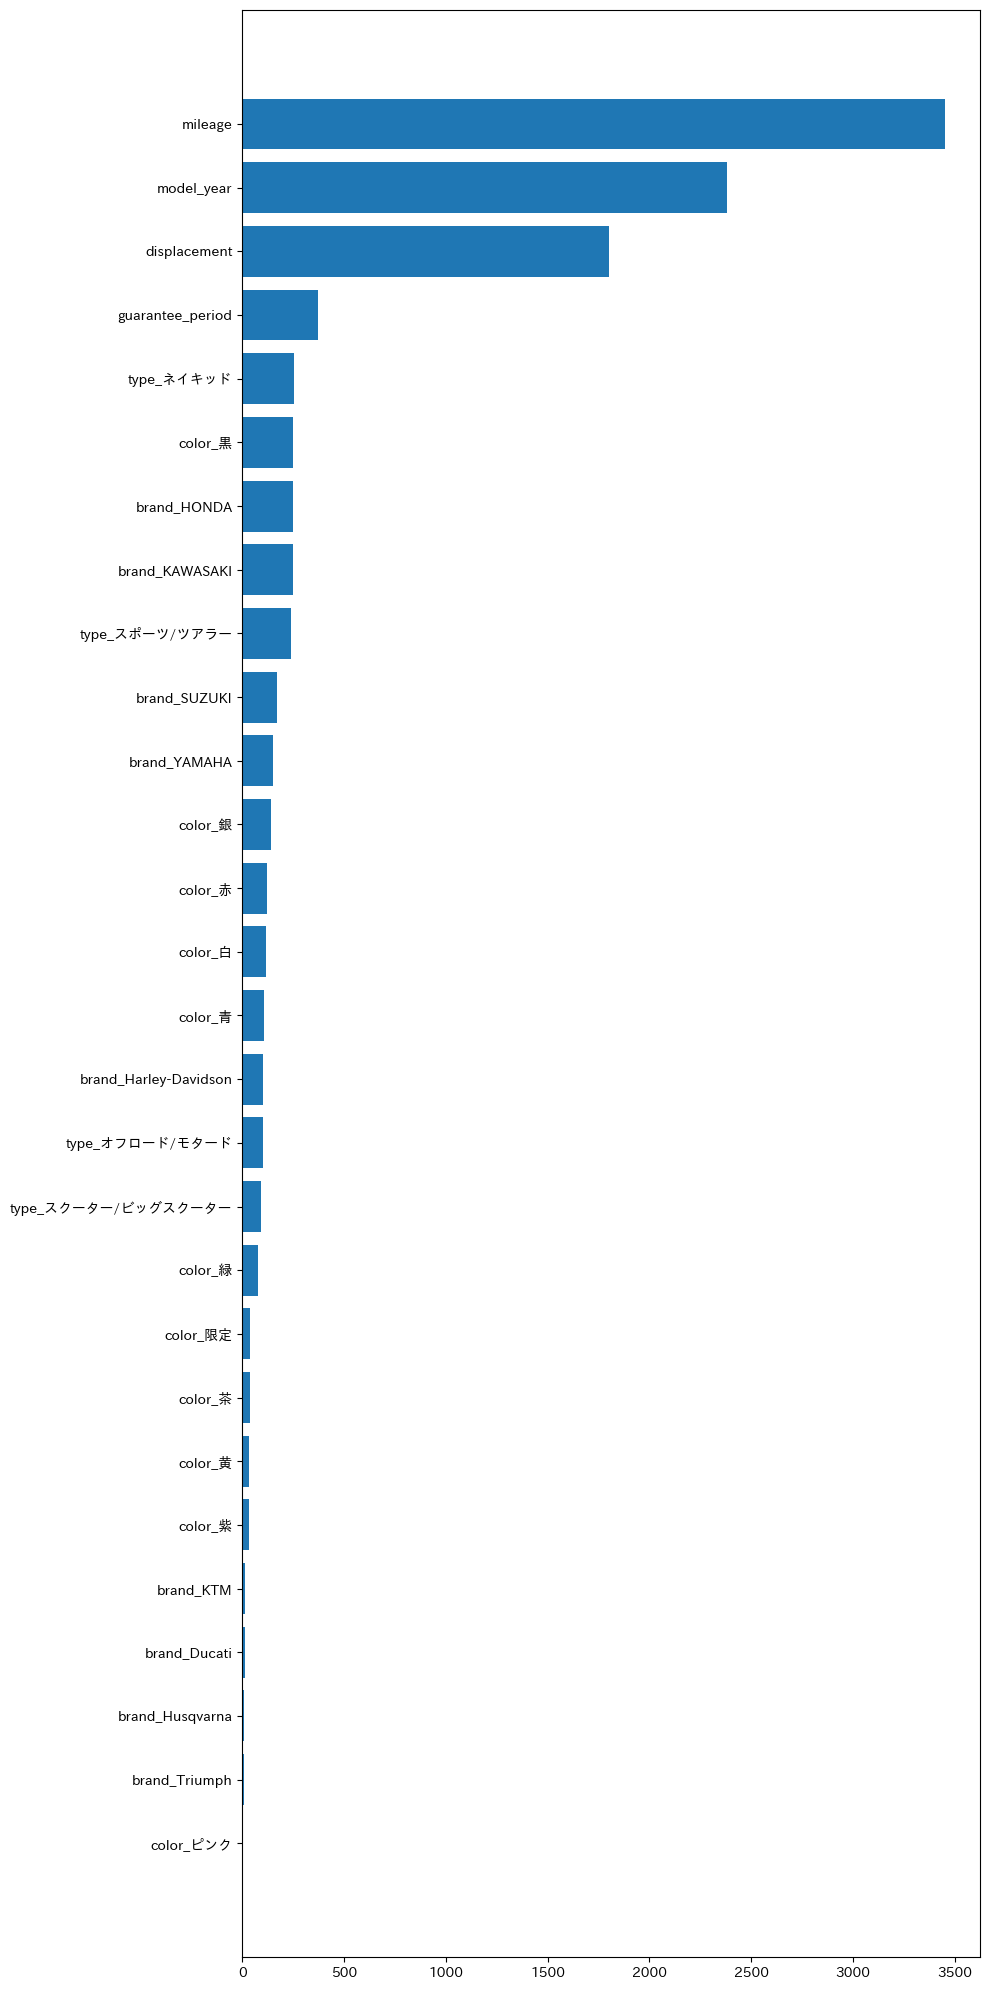

In [14]:
#feature_importanceも確認してみる
plt.subplots(figsize=(10,20))
featuer_name = train_data.drop(columns=['id','cost','model_number','name','store_id']).columns
importances = model_2.feature_importance()
indices = np.argsort(importances)
plt.barh(np.asarray(featuer_name)[indices],importances[indices])
plt.tight_layout()
plt.show()


In [15]:
test_data = pd.read_csv('../data/機械学習用/test_data.csv',index_col=0)
test_data=test_data.merge(model_data,on='model_number',how='left')
test_data.dropna(inplace=True)

In [16]:
test_data

,id,cost,model_number,model_year,color,mileage,guarantee_period,store_id,brand,name,type,displacement
0,2100005197021,128000,EBJ-SE53J,2011.0,銀,9937.0,0.25,64,YAMAHA,ｱｸｼｽﾄﾘｰﾄ,スクーター/ビッグスクーター,125.0
1,2100006010725,148000,BA-AF58,2004.0,黒,9317.0,0.25,75,HONDA,ｽﾞｰﾏｰ,スクーター/ビッグスクーター,50.0
2,2100006174472,598000,2BK-MC49,2020.0,青,1000.0,5.00,50,HONDA,ﾚﾌﾞﾙ250,アメリカン/クルーザー,250.0
3,2100005171830,458000,2BJ-JC79,2021.0,銀,4349.0,1.00,61,HONDA,CB125R,ネイキッド,125.0
4,2100006114140,158000,JBH-AF77,2019.0,緑,22.0,1.00,21,HONDA,ｼﾞｮﾙﾉ,スクーター/ビッグスクーター,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1117,2100006064599,138000,2BH-AF79,2016.0,銀,4610.0,0.25,21,HONDA,ﾀｸﾄﾍﾞｰｼｯｸ,スクーター/ビッグスクーター,50.0
1118,2100004942059,648000,JBK-BJ250A,2017.0,オレンジ,12514.0,3.00,43,KAWASAKI,ｴｽﾄﾚﾔ,ネイキッド,250.0
1119,2100005245517,2098000,8BL-EJ11A,2022.0,銀,1446.0,7.00,10,SUZUKI,ﾊﾔﾌﾞｻ,スポーツ/ツアラー,1300.0
1120,2100006294828,498000,BC-RH01J,2007.0,黒,2506.0,0.25,3,YAMAHA,SR400,ネイキッド,400.0


In [17]:
#ダミーエンコーディング
test_data = pd.get_dummies(test_data,drop_first=True,columns=encoding_target)


In [18]:
X_test=test_data.iloc[:,2:].drop(columns=['name','model_number','store_id']).values
y_test = test_data['cost'].values

In [19]:
train_ds = opt_lgb.Dataset(X,y)
test_ds = opt_lgb.Dataset(X_test,y_test)


model_2 = lgb.train(best_params,
                    train_set= train_ds,
                    valid_sets= test_ds,
                    num_boost_round=10000,
                    callbacks=[lgb.early_stopping(stopping_rounds=100,verbose=100)])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 421
[LightGBM] [Info] Number of data points in the train set: 4482, number of used features: 28
[LightGBM] [Info] Start training from score 736169.908523
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	valid_0's mape: 0.151485


In [20]:
predict_train = model_2.predict(X)
predict_test = model_2.predict(X_test)

In [21]:
print('訓練データ決定係数',r2_score(y_true=y,y_pred=predict_train))
print('テストデータ決定係数',r2_score(y_true=y_test,y_pred=predict_test))
print('訓練データMAPE',mean_absolute_percentage_error(y_true=y,y_pred=predict_train))
print('テストデータMAPE',mean_absolute_percentage_error(y_true=y_test,y_pred=predict_test))

訓練データ決定係数 0.9930417113209444
テストデータ決定係数 0.7554628038835202
訓練データMAPE 0.0647482708081837
テストデータMAPE 0.15148504193898804
